### **🔁 BORN-AGAIN NEURAL NETWORKS (BANs) FROM SCRATCH.**

Traditionally, information has been transferred between teacher and student models via a process known as **Knowledge Distillation** (KD). The goal of KD is simple - to train an initial teacher model, and then train a smaller student model in effort to achieve equivalent performances in a smaller parameter space. This student model can be trained in three main ways. The simplest and most common of these is known as **response-based distillation**, where the **distillation loss** is calculated simply by measuring the Euclidean distance between the student and teacher predictions. But, this of course is no guarantee that the student is learning the same underlying relationship as the teacher - **Feature-Based distillation** aims to solve this problem by attempting to match the **feature activations at the end of each layer** (attempting to coerce the student to learn similar feature maps to the teacher). More advanced and accurate still is **Relation-Based distillation** - rather than attempting to match the outputs of some layer or model, RKD aims to transfer **structural knowledge** regarding the relationship of different nodes (for example, calculating the angle formed by three given nodes or the distance between them). In any case, the **objective of such methods has always been to DISTILL information into a smaller form.**

This begs the question - if **smaller student models can achieve equivalent accuracies, can student models of equivalent size obtain HIGHER accuracies than their teachers?** This is, fundamentally, a Born-Again Neural Network (BAN) - a student model identically parametrized to its teacher, an effort that *surprisingly leads to the students (drastically) outperforming their respective teacher models.* This project will be replicating the original BAN paper (found at https://arxiv.org/pdf/1805.04770.pdf).

The purpose of this project/mini-experiment is to 1️⃣ **determine whether Dark Knowledge-based relationships (as we'll discuss further) are instrumental in how networks learn and generate predictions**, 2️⃣ understand from first-principles the theoretical nature of BAN distillation losses (Confidence Weighting by Teacher Max and Dark Knowledge with Permuted Predictions) and their practical nature via **implementing them from scratch in PyTorch**, 3️⃣ further uncover why **BANs tend to achieve higher overall accuracies when compared to teachers** (i.e. "re-learning" identical relationships but in more "effective" terms), and 4️⃣ **test the Dark Knowledge and BAN accuracy hypothesis via training an ensemble of 5 WideResNet 28-1 student models against a DenseNet 121 teacher**.

Let's get into it!

### 🤔 **The Math Behind BANs - Confidence Weighting, Dark Knowledge, and More.**

For a typical BAN system, the training procedure looks something like this (where $x$ is the input data, $T$ represents the initial teacher model, $S_k$ represents the $i-th$ student learner, $f(x)$ represents the classifier learned by the model, and $y$ represents the generated predictions):

<p align = "center"><img src = "./images/BAN_TRAINING_PROCEDURE.png"></img></p>

In essence, each student learns from the student that came before it - student $S_k$ learns from student $S_{k-1}), and student $S_k$ learns from the initial teacher $T$. Once this ensemble has been trained, there are two options: one can either simply take the final student model, or one can "batch" the student models together into **a model ensemble**, where for a given input, the predictions of each model within the ensemble are averaged (or combined in some other way) to generate the final prediction. Generally speaking, model ensembles are prone to **higher accuracies** as they cover a larger proportion of hypothesis space, and thus can fit a wider set of distributions. 

#### **👆 What's the point of BANs?**

Fundamentally, the idea of the BAN is that **the teacher model's activations and end prediction distribution (i.e. the probability distribution of whatever predictions have been generated) contain critical information in ADDITION to the training set that can result in better predictions.** Analogically, it is much like a student learning not only the required material, but additional information beyond said material that may drastically boost their academic performance. Mathematically, this operates on the principle that **minimizing the LOSS FUNCTION of a given task is not necessarily the same as minimizing generalization error.**

While a teacher model may have drastically minimized the loss function, this does not meant that it is proficient in the given task; or that the classifier it has learned in hypothesis space is adept enough to fit most possible distribution. But, it is also possible that **in the process of optimizing the loss function, the teacher model stumbled upon some critical insights that can serve to be instrumental in improving model generalization.**

So, if we were to learn **from both the training set AND the teacher**, we increase the amount of potentially relevant available information - the student can now use the teacher's predictions and learned patterns as a starting point, potentially learning more advanced and accurate classifiers.

#### **🪄Dark Knowledge - and why it matters.**

Let's say that a certain model is trying to classify a dog, train, car, and cat. Let's say that we want to test the model on the picture of a dog. When we pass in this image and apply the SoftMax activation, we'll get something like this:

*Quick refresher - the SoftMax activation takes a set of input values, and changes them into probabilities between 0 and 1. For a given vector $z_i$, $\sigma$ (SoftMax) $z_i$ is given by:*

$$ \sigma(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K $$

*In other words - for each logit, it is simply $E^{prob}$ divided by the SUM of $e$ raised to all of the other probabilities. This function will be important later!*

<center>

|  Dog  |  Car  | Train |  Cat  |
|-------|-------|-------|-------|
|0.9    | 0.002 | 0.001 |0.0897 |

</center>

Now, if we were trying to extract a prediction from the model, the end answer is simple - the model obviously predicted dog (with the highest probability at 90%). We might even try to use this information for KD - simply checking if **both the teacher and student model predicted dog as their end prediction.**

But, **there's a huge problem with this approach - it ignores the probabilities of the remainder of the labels. More accurately, it ignores the fact that the model stated that the given image was more likely to be a cat than a car, and more likely to be a car than a train.** This might be hard to tell because the numbers are so small - so, let's introduce something known as **temperature** in the above SoftMax formula so that we can see those other predictions better **without affecting the order of the predictions.**

It's pretty simple - all we need to do is **divide the probability by some temperature constant $T$ to rescale the values.** The HIGHER the temperature, the **"softer" the distribution**, and the LOWER the temperature, the "sharper" (more drastic differences between labels) the distribution (generally speaking). Here's SoftMax with temperature:

$$ \sigma(z_i) = \frac{e^{\frac{z_{i}}{T}}}{\sum_{j=1}^K e^{\frac{z_{j}}{T}}} \ \ \ for\ i=1,2,\dots,K $$

Now, if we apply an arbitrarily high temperature to our previous distribution: (*these values are just for demonstration purposes and NOT REAL!*)

<center>

|  Dog  |  Car  | Train |  Cat  |
|-------|-------|-------|-------|
|0.4    | 0.09  | 0.04  |0.27   |

</center>

In percentages for clarity:

<center>

|  Dog  |  Car  | Train |  Cat  |
|-------|-------|-------|-------|
| 40%   | 9%    | 4%    | 27%   |

</center>

Now, we can **clearly see that the model believes that the image is more likely to be a cat than a car** - this indicates that the model **has learned a relationship: that animals are different from objects.** Other ANIMALS are more likely to be confused with other animals, whereas an animal is drastically less likely to be confused with an object like a car. 

#### **This is dark knowledge - hidden relationships the model has learned that can be critical in completing the task at hand that can be found in its underlying probability distribution** learning that animals $\ne$ things is a critical first step in distinguishing the classes.

If this Dark Knowledge (DK) hypothesis holds true, then **it makes sense that transferring this DK between teachers and students should be critical in KD and in training BANs.** But, **is it really dark knowledge information transfer that makes knowledge distillation successful?**

Let's explore this further.

#### 📚 **Is Dark Knowledge Truly Important? Confidence Weighting.**

Remember how I said that the SoftMax function would be useful? Now's the time to use it.

First, let's understand **cross entropy loss.** The SoftMax function is an **activation - it normalizes our logits, but does NOT tell us the loss.** This is where cross entropy comes in - it compares two SoftMax-activated distributions and **returns the error between the two.** The underlying logic is simple -> simply multiply **the true probability distribution** by the log (usually natural log) of the given distribution **for each value** (i.e. compare the dog values, then the car, train, and cat, etc.) and simply sum them up!

$$ \ell(p, q) = -\sum_{∀x}p(x)log(q(x)) $$ 
...where $p(x)$ is the true distribution and $q(x)$ is the predicted distribution.

When we perform gradient descent, we must compute the **gradient or partial derivative** of this function with respect to the $i_{th}$ parameter $z_i$ - in other words, we must compute the value of $ \frac{∂ \ell}{∂ z_i} $. Here's the cool part: **the partial derivative of the cross entropy loss function is just the current distribution minus the true distribution!** And, if we **expand both $q_i$ and $p_i$ to reveal how they were calculated** (remember that the SoftMax activation was applied first to obtain both $q_i$ and $p_i$ - we are simply expressing those two variables in terms of the SoftMax calculation), we get:

$$ \frac{∂l_i}{∂z_i}=q_i-p_i=\frac{e^{z_i}}{Σ_{j=1}^ne^{z_j}}-\frac{e^{t_i}}{Σ_{j=1}^ne^{t_j}} $$

Remember that, for any given student model, the true distribution for it would be the teacher's distribution (not the distribution of the actual dataset labels). So here, $p_i$ serves as the **teacher's prediction distribution** whereas $q_i$ **serves as the student's prediction distribution.**

Let's suppose for a second, that instead of the $i_{th}$ element of the predictions, we are on the TRUE predicted element (represented by $*$). In the context of the previous example, this would mean that we were currently on the "Dog" class, the class/element with the highest probability. Now, let's suppose **that the teacher is EXACTLY accurate for this example - that is, instead of outputting 0.9 or 0.5 for this class, it outputted a perfect 1.0.** In this case, the distribution would look something like this:

<center>

|  Dog  |  Car  | Train |  Cat  |
|-------|-------|-------|-------|
| 1.0   | 0.0   | 0.0   | 0.0   |

</center>

Let's now draw our attention back to $p_i$, which is the SoftMax of the given element. Since we are on the highest element (the "true" prediction) and it perfectly matches the "target" distribution (the distribution of the actual dataset - **remember that the dataset, after being one-hot encoded, just has 1 for the true class and 0 for everything else**), then this term **will simply yield 1**!

So, the **partial derivative when the teacher's true prediction exactly matches the target distribution (and when we are iterating over that true prediction $*$)**
$$ \frac{∂l_i}{∂z_i}=q_i-p_i=\frac{e^{z_i}}{Σ_{j=1}^ne^{z_j}}-1.0 $$

Let's now consider taking **the partial derivative across not just the $i_{th}$ sample, but an entire batch of size $b$.** We can add these **partial derivatives together to obtain the AVERAGE PARTIAL DERIVATIVE for each batch - simply divide by the batch size:**

$$ L(x_1,t_1..x_b,t_b)=\frac{1}{b}\sum^{b}_{s=1}L(x_s,t_s) $$


In this case, let $n$ represent each *individual prediction* (iterating over Dog, Car, Train, and Cat for each and every probability distribution rather than just iterating over each distribution). Now, let's take the average **partial derivative** instead of the average loss function - in other words, **let's find the partial derivative of the above average loss to yield the average gradient for a given parameter across a minibatch.**

$$ \frac{1}{b}\sum^b_{s=1}\sum^n_{i=1}\frac{∂L_{i,s}}{∂z_{i,s}}=\frac{1}{b}\sum^{b}_{s=1}(q_{*,s}-p_{*,s})+\frac{1}{b}\sum^b_{s=1}\sum^{n-1}_{i=1}(q_{i,s}-p_{i,s}) $$

In [1]:
#Import Libaraies
from fastai.vision.all import *
import fastai 
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\mindf\anaconda3\envs\ml_mastery_replicates\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Load Dataset. We will be testing the teacher and student models, first and foremost, on the Imagenet Dataset
#This is as one of the key criticisms of the original paper was that only CIFAR-100 was used to validate the given findings
#As actually training a model on the full ImageNet dataset would require more compute, processing pwoer, and time than currently available, use 
#FastAI's Imagenette and Imagewoof instead - combined into one, the Imagewang dataset.

#Use the 160 px version to save training time
Imagewang_path = untar_data(URLs.IMAGEWANG_160)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


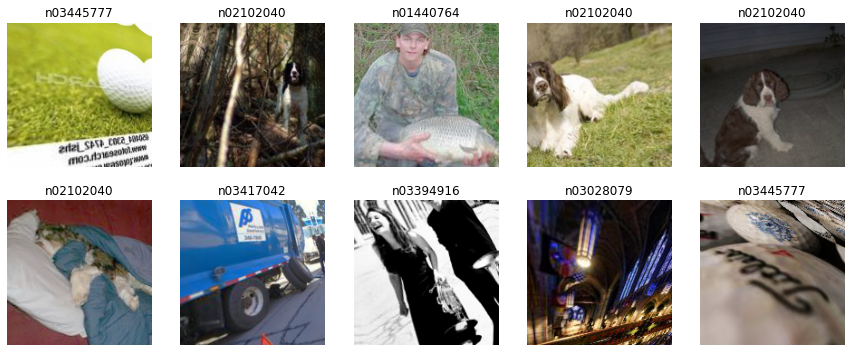

In [3]:
#Create Training Datablock for the teacher model
teacher_train_datablock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                                       get_items = get_image_files,
                                       get_y = parent_label,
                                       splitter = RandomSplitter(valid_pct = 0.25, seed = 25),
                                       batch_tfms = aug_transforms(mult = 2.),
                                       item_tfms = Resize(160))
#Create a dataloader for the teacher model
batch_size = 64
teacher_train_dataloader = teacher_train_datablock.dataloaders(source = Imagewang_path/"train", batch_size = batch_size, shuffle = True)
#Print sample batch of 10 samples
teacher_train_dataloader.train.show_batch(max_n = 10, nrows = 2)

#### **TRAIN TEACHER MODEL (DENSENET 121).**

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.352293,0.427742,0.883011,0.116989,2:32:47
1,0.616427,0.201454,0.945187,0.054813,2:48:17
2,0.385142,0.144807,0.958277,0.041723,2:08:12


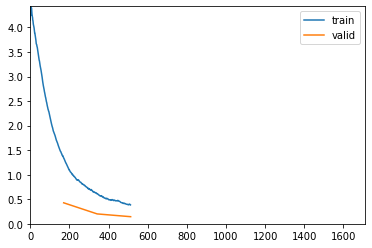

KeyboardInterrupt: 

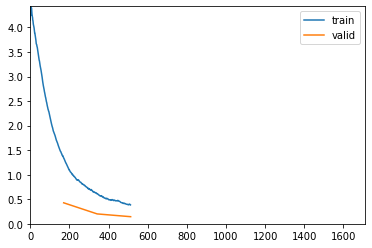

In [ ]:
#Load a pretrained Densenet-121 from FastAI to be used as an initial teacher model. The objective is to get the student ensemble (composed of the less complex ResNets)
#to surpass the accuracy of the teacher model.
#T - teacher model, S - student model
DenseNet121_learner_T = vision_learner(teacher_train_dataloader, densenet121, metrics = [accuracy, error_rate])
#Train the model on 10 epochs - as the model is already pretrained, this is morethan sufficient
#Ensure that the model layers are all frozen for the entire training procedure
n_epochs = 10
lr = 0.001
DenseNet121_learner_T.fine_tune(n_epochs, lr, n_epochs, cbs = [ShowGraphCallback])

In [11]:
#Save DenseNet model
DenseNet121_learner_T.save("DENSENET_121_TEACHER")

Path('models/DENSENET_121_TEACHER.pth')

#### **IMPLEMENT STUDENT MODEL LOGIC.**

In [4]:
#Import distillation loss fuctions - CWTM (Confidence Weighting by Teacher Max) and DKPP (Dark Knowledge with Permuted Predictions)
from CWTM_Distillation_Loss import CWTM_DistillationLoss
from DKPP_Distillation_Loss import DKPP_DistillationLoss
#Import torch.nn.functional for one-hot encoding
import torch.nn.functional as F
#Import tqdm for progress bar
from tqdm import tqdm

#Train student model ensembles
def trainStudentEnsembles(initial_teacher, student_model_type, n_students = 5, CWTM = True, DKPP = False):
    #Generate new datablock and dataloader for student ensembles
    student_train_datablock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                                        get_items = get_image_files,
                                        get_y = parent_label,
                                        splitter = RandomSplitter(valid_pct = 0.25, seed = 25),
                                        batch_tfms = aug_transforms(mult = 2.),
                                        item_tfms = Resize(160))
    student_train_dataloader = student_train_datablock.dataloaders(source = Imagewang_path/"train", batch_size = batch_size, shuffle = True)
    #Iterate over number of student models
    for student_number in range(1, n_students):
        #For each student model, generate a new learner object
        globals()[student_model_type.__name__ + "_" + str(student_number) + "_S"] = vision_learner(student_train_dataloader, student_model_type, metrics = [accuracy, error_rate], pretrained = False)
        #Check if we are on the first iteration (i.e. no student models have been trained) - in this case, use the initial teacher model as the teacher
        #rather than the previous student
        if student_number == 1:
            globals()[student_model_type.__name__  + "_" + str(student_number) + "_S" + "metrics"] = trainStudent(globals()[student_model_type.__name__ + "_" + str(student_number) + "_S"], 
                                                                                                           initial_teacher, CWTM, DKPP)
        else:
            #If we are not on the first iteration, use the previous student model as the teacher
            globals()[student_model_type.__name__  + "_" + str(student_number) + "_S" + "metrics"] = trainStudent(globals()[student_model_type.__name__ + "_" + str(student_number) + "_S"], 
                                                                                                           globals()[student_model_type.__name__ + "_" + str(student_number-1) + "_S"], 
                                                                                                           CWTM, DKPP)
        #Save student model
        globals()[student_model_type.__name__  + "_" + str(student_number) + "_S"].save(student_model_type.__name__ + "_STUDENT_" + str(student_number) + "MODEL")
    #Generate two subplots - one for losses, and the other for accuracies
    #Display metrics for each student while doing so
    #Create loss subplot
    loss_figure, loss_axes = plt.subplots(n_students, figsize = [24, 18])
    #Plot loss metrics
    plotStudentMetrics(loss_axes, "loss", student_model_type)
    #Create accuracy subplot
    accuracy_figure, accuracy_axes = plt.subplots(n_students, figsize = [24, 18])
    #Plot accuracy metrics
    plotStudentMetrics(accuracy_axes, "accuracy", student_model_type)

#Function to plot various student metrics (loss and accuracy) within a parent subplot
def plotStudentMetrics(axes, metric, student_model_type):
    #Iterate over axes
    for ax_num, ax in enumerate(axes):
        #Plot training losses
        ax.plot(globals()[student_model_type.__name__  + "_" + str(ax_num + 1) + "_S" + "metrics"]["TRAIN"][metric], label = "TRAINING " + metric.upper())
        #Plot validation losses
        ax.plot(globals()[student_model_type.__name__  + "_" + str(ax_num + 1) + "_S" + "metrics"]["VALID"][metric], label = "VALIDATION " + metric.upper())
        #Set titles and labels
        ax.set_title(student_model_type.__name__  + "STUDENT " + str(ax_num + 1) + "LOSSES.")
        ax.set_xlabel("EPOCH")
        ax.set_ylabel(metric.upper())
        #Display legend
        ax.legend(loc = "upper right")

#Import mode for mode calculations
from statistics import mode
#Generate predictions from student model ensembles
def getStudentEnsemblePredictions(input, student_model_type, n_students):
    #Logits and final predictions - these will be averaged to find the logits and predictions of the ensemble
    all_logits, all_predictions = []
    #Iterate over each student
    for student in n_students:
        logits, _, prediction = globals()[student_model_type.upper() + "_" + student + "_S"].predict(input)
        all_logits.append(logits)
        all_predictions.append(prediction)
    #Find the average of all logits and the MODE of all predictions (as they are categorical)
    avg_logits = sum(all_logits)/len(all_logits)
    mode_prediction = mode(all_predictions)
    #Return average logits and most common prediction
    return avg_logits, mode_prediction

#Train function for indiivdual student models
def trainStudent(student_model, teacher_model, epochs = 10, lr = 0.001, batch_size = 64, CWTM = True, DKPP = False):
    #Create metrics dictionary
    metrics = {"TRAIN" : {"loss" : None, "accuracy" : None}, "VALID" : {"loss" : None, "accuracy" : None}}
    #Iterate over epochs
    for epoch in range(epochs):
        #Training loop, store losses and accuracies in respective dictionary elements
        train_loss, train_acc = modelCycle(student_model, teacher_model, epoch, CWTM, DKPP)
        metrics["TRAIN"]["loss"] = train_loss
        metrics["TRAIN"]["accuracy"] = train_acc
        #Validation loop (same structure as above)
        valid_loss, valid_acc = modelCycle(student_model, teacher_model, epoch, CWTM, DKPP, valid = True)
        metrics["VALID"]["loss"] = valid_loss
        metrics["VALID"]["accuracy"] = valid_acc
        #If on the last epoch, return metrics
        if epoch == epochs - 1: return metrics

#Function to handle training loop
def modelCycle(student_model, teacher_model, epoch, CWTM, DKPP, valid = False):
    batch_losses = []
    correct = 0
    #For each epoch, iterate over a batch (the dataloader used already has this parameter specified)
    #batch_data currently holds the TRUE (y) labels of the dataset
    #Use tqdm for progress bar
    for batch_number, batch_data in enumerate(tqdm(teacher_model.dls.train, unit = "Batch"), 0):
        #Set student model gradient to zero
        student_model.zero_grad()
        #Get inputs and true labels
        inputs, y_labels = batch_data
        #Generate student predictions
        student_preds = student_model.model(inputs)
        #Generate teacher predictions
        teacher_preds = teacher_model.model(inputs)
        #If we are using the CWTM distillation loss, then we must ALSO pass in the true labels in addition to the teacher and student predictions
        if CWTM: 
            loss_func = CWTM_DistillationLoss.apply
            #One hot encode the true y-labels
            # one_hot_y_labels = torch.tensor(F.one_hot(y_labels), dtype = torch.float64)
            # print(one_hot_y_labels.shape)
            #Calculate the loss
            loss = loss_func(student_preds, teacher_preds, y_labels)
        elif DKPP: 
            loss_func = DKPP_DistillationLoss.apply
            loss = loss_func(student_preds, teacher_preds)
        #If this is a validation loop, do not compute gradients or take a step
        if not valid:
            #Compute gradients based on loss
            loss.backward()
            #Take a step with the optimizer
            student_model.opt.step()
        #Add loss to batch_losses array - use .item to convert scalar to float
        batch_losses.append(loss.item())
        #Calculate accuracy - find the max label of both the student and teacher models and compare them
        #The accuracy is NOT as reliable of a measure of student-learning from teacher as the distillation loss
        true_student_preds, idxs = torch.max(student_preds, 1)
        true_teacher_preds, idxs = torch.max(teacher_preds, 1)
        #Find the number of correct samples
        correct += torch.eq(true_student_preds, true_teacher_preds).sum().item()
        #Check if we are on the final sample of the batch - if so, output metrics
        if batch_number == batch_size - 1:
            #Calculate average batch loss and append to losses array
            avg_batch_loss = sum(batch_losses)/len(batch_losses)
            batch_losses.append(avg_batch_loss)
            #Calculate accuracy
            batch_accuracy = 100 * correct / batch_size
            #Display loss and accuracy
            print("TRAINING EPOCH [{}]: LOSS = {}, ACCURACY = {}".format(epoch, avg_batch_loss, batch_accuracy))
            #Return batch loss and accuracy
            return avg_batch_loss, batch_accuracy

#### **TRAIN STUDENT MODELS ON DENSENET TEACHER.**

In [5]:
#Redeclare DenseNet121 Learner
DenseNet121_learner_T = vision_learner(teacher_train_dataloader, densenet121, metrics = [accuracy, error_rate])
#Load model
DenseNet121_learner_T.load('DENSENET_121_TEACHER')

In [6]:
#Train students with CWTM (Confidence Weighting by Teacher Max) Distillation Loss
trainStudentEnsembles(DenseNet121_learner_T, resnet18)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


  0%|          | 0/171 [00:00<?, ?Batch/s]

torch.Size([64])
TensorCategory([ 8, 17, 12,  0, 11, 13,  8, 13,  8, 15, 19, 16, 17, 15, 16, 17, 16,  0,
        17, 15,  8, 14,  8, 13, 12, 13, 13, 16, 14, 14, 17, 19,  5, 18, 18, 19,
        10,  0, 12, 17,  4, 13, 19, 18, 13, 15, 16, 19,  3, 19,  8, 13, 17, 12,
         7,  0, 18,  0, 17, 16, 19, 15, 19, 16])
torch.Size([64])
tensor([15, 19, 11,  9,  4, 11, 18,  4, 10,  0, 14,  9,  6, 10,  2,  8,  3,  3,
        15,  0, 10,  7, 12, 13,  7, 18,  5,  8,  7, 14, 13,  8,  6,  2,  6,  3,
         1, 14, 18,  9,  7, 14, 14, 15,  0, 18, 15, 18, 15,  5, 18, 14, 17, 11,
        17, 18, 13, 18, 18, 10,  6, 10,  5, 16])


  0%|          | 0/171 [01:12<?, ?Batch/s]


RuntimeError: Function CWTM_DistillationLossBackward returned an invalid gradient at index 0 - got [64] but expected shape compatible with [64, 20]

In [ ]:
#Train students with DKPP (Dark Knowledge with Permuted Predictions) Distillation Loss
trainStudentEnsembles(DenseNet121_learner_T, resnet18, CWTM = False, DKPP = True)

#### **TRAIN STUDENT ENSEMBLES ON ALTERNATE TEACHERS.**